### Метод минимизации мажоранты (Majorization-minimization).

Мажоранта (миноранта) - функция, значения которой не меньше (больше), чем значения данной функции.
Идея метода оптимизации с помощью минимизации мажоранты (верхней оценки) показана на рисунке:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/37a67228271527037c9250ae3fd220199275e42e/1-Figure1-1.png" width=400>

На $k$-й итерации метода в точке $x_k$ строится верхняя оценка $g(x|x_k)$ целевой функции $f(x)$, такая что:

$f(x) \leq g(x|x_k)$

$f(x_k) = g(x_k|x_k)$

Затем следующее промежуточное решение $x_{k+1}$ находится минимизацией верхней оценки целевой функции

$x_{k+1} = \arg\min_x g(x|x_k)$

Эффективность метода зависит от того, насколько эффективно решается эта задача оптимизация.

http://www.machinelearning.ru/wiki/images/f/f1/MOMO12_upper_bounds.pdf

Majorization-Minimization Algorithms in Signal Processing, Communications, and Machine Learning: 
http://www.ece.ust.hk/~palomar/Publications_files/2017/SunBabuPalomar-TSP2017%20-%20MM.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Пример 1:

$f(x) = |x|$

$|x| \leq \frac{x^2}{2|x_k|} + \frac{|x_k|}{2}$


http://eeweb.poly.edu/iselesni/lecture_notes/TVDmm/TVDmm.pdf

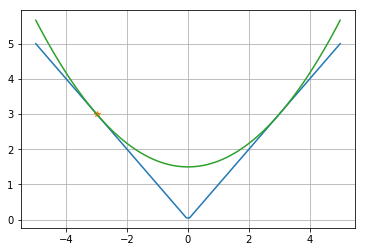

In [2]:
t = np.linspace(-5, 5, 100)
t0 = -3.
plt.plot(t, np.abs(t))
plt.plot(t0, np.abs(t0), '*')
plt.plot(t, 0.5*t**2/np.abs(t0) + 0.5*np.abs(t0))
plt.grid('on')
plt.show()

Рассмотрим задачу

$$ f(x) = \frac{1}{2}\|x-y\|^2 + \lambda\|Dx\|_1 $$

Найдем верхнюю границу для второго слагаемого $\|z\|_1 = \sum_i |z_i|$. Используя верхнюю границу для модуля, получим:

$\|Dx\|_1 \leq \frac{1}{2}\|Dx_k\|_1 + \frac{1}{2} x^TD^T \Lambda_k^{-1}Dx$, где $\Lambda_k = \mathrm{diag}(|Dx_k|)$

$g(x|x_k) = \frac{1}{2}\|x-y\|^2 + \frac{\lambda}{2}\|Dx_k\|_1 + \frac{\lambda}{2} x^TD^T \Lambda_k^{-1}Dx = \frac{1}{2} x^T(I + \lambda D^T \Lambda_k^{-1} D)x - y^Tx + \mathrm{const}$

Эта квадратичная функция, задача минимизации которой имеет аналитическое решение:

$\nabla g(x|x_k) = (I + \lambda D^T \Lambda_k^{-1} D)x - y = 0$

$x_{k+1} = (I + \lambda D^T \Lambda_k^{-1} D)^{-1}y$

Используя тождество Вудбери (Sherman–Morrison–Woodbury formula)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/3ffa2c14bb438728d93f2cdf7ea6657338ab8fb7">

$(I + \lambda D^T \Lambda_k^{-1} D)^{-1} = I - D^T \left(\frac{1}{\lambda}\Lambda_k + D D^T \right)^{-1} D$

$x_{k+1} = y - D^T \left(\frac{1}{\lambda}\mathrm{diag}(|Dx_k|) + D D^T \right)^{-1} D y$

Landweber iteration

http://eeweb.poly.edu/iselesni/lecture_notes/sparse_signal_restoration.pdf

The size of the image is 512 x 512.


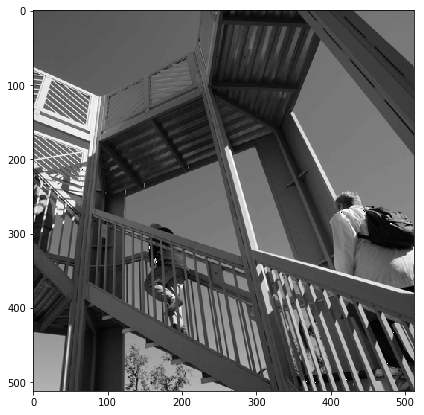

In [2]:
from scipy import misc
x = misc.ascent()
x = np.double(x)/255.

#x = x[100:120,100:120]

print("The size of the image is %s x %s." % (x.shape[0],x.shape[1]))

plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

In [3]:
(N1,N2) = x.shape
y = x + 0.1*np.random.randn(N1,N1)

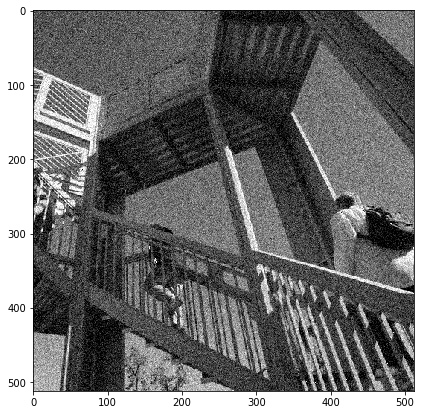

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(y, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

In [5]:
def D(x):
    vdiff = np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])] # the r_ command concatenates along the rows
    hdiff = np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])] # the c_ command concatenates along the columns
    return np.concatenate((vdiff[...,np.newaxis], hdiff[...,np.newaxis]), axis=2) # combination along a third dimension

In [6]:
def Dadj(x):
    r = np.r_['0,2',-x[0,:,0],-np.diff(x[:-1,:,0],1,0),x[-2,:,0]]
    c = np.c_['1,2',-x[:,0,1],-np.diff(x[:,:-1,1],1,1),x[:,-2,1]]
    return r+c

In [3]:
from scipy.optimize import minimize
from scipy.sparse.linalg import bicg

# solves A*x = b
def solve_linear(A, b): 
       
    def f(x):
        x = x.reshape(b.shape)
        return np.sum(x*(0.5*A(x) - b))
        #return 0.5*np.sum(x*A(x)) - np.sum(b*x)
    
    def fgrad(x):
        x = x.reshape(b.shape)
        return (A(x) - b).flatten()
    
    x0 = np.random.rand(*b.shape)
    res = minimize(f, x0, jac=fgrad, method='L-BFGS-B', options={'disp':True, 'maxiter':200})
    return res.x.reshape(b.shape)
    

In [4]:
A_mat = np.array([[3,1],[1,2]])
b = np.array([1,2])

from scipy.linalg import solve

x_1 = solve(A_mat, b)
print(x_1)

A_op = lambda x: np.dot(A_mat, x)

x_2 = solve_linear(A_op, b)

print(x_2)

[ 0.  1.]
[ -8.89984507e-08   1.00000036e+00]


In [44]:
from scipy.linalg import norm

max_iter = 20

Lambda = 0.1


objective = lambda x: 0.5*norm(x - y)**2 + Lambda*np.sum(np.abs(D(x))) 

xx = y
f_old = np.inf
# Dy = D(y)
for k in range(max_iter): 
    
    f = objective(xx)
    if np.abs(f - f_old) < 0.01:
        break
    
    f_old = f
    print('{}: f = {:.3f}'.format(k, f))
    
    A = lambda x: 1/Lambda*np.abs(D(xx))*x + D(Dadj(x))

    z = solve_linear(A, D(y))
    xx = y - Dadj(z)
    
x_denoised_L1 = xx

0: f = 6419.538
1: f = 2877.224
2: f = 2315.097
3: f = 2154.971
4: f = 2094.609
5: f = 2067.348
6: f = 2053.749
7: f = 2046.192
8: f = 2041.544
9: f = 2038.711
10: f = 2037.640
11: f = 2036.285
12: f = 2035.032
13: f = 2034.454
14: f = 2033.915
15: f = 2034.605
16: f = 2033.678
17: f = 2033.557
18: f = 2034.031
19: f = 2032.918


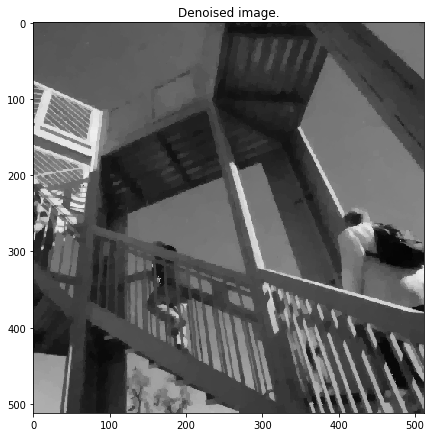

In [45]:
plt.figure(figsize=(7,7))
plt.imshow(x_denoised_L1, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.subplots_adjust(top=3)
plt.title('Denoised image.')
plt.show()

Пример 2:

$f(x) = \sqrt{x}$

$\sqrt{x} \leq \sqrt{x_k} + \frac{1}{2\sqrt{x_k}}(x - x_k)$

http://www.lx.it.pt/~bioucas/files/Figueiredo_et_al_ICIP2006.pdf

http://www.lx.it.pt/~jpaos/Joao/Joao_Oliveira_files/Dias_Figueiredo_Oliveira_ICASSP06.pdf

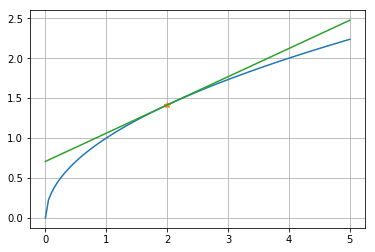

In [129]:
t = np.linspace(0, 5, 100)
t0 = 2.
plt.plot(t, np.sqrt(t))
plt.plot(t0, np.sqrt(t0), '*')
plt.plot(t, np.sqrt(t0) + 0.5/np.sqrt(t0)*(t - t0))
plt.grid('on')
plt.show()

Рассмотрим задачу

$$ f(x) = \frac{1}{2}\|x-y\|^2 + \lambda \mathrm{TV}(x) $$


где $\mathrm{TV}(x) = \|Dx\|_{2,1} = \sum_i \sqrt{ v_i^2 + h_i^2}$ и

$$\left[
\begin{array}{c} 
v \\ 
h 
\end{array}
\right] 
= 
\left[
\begin{array}{c}
D_V \\
D_H
\end{array}
\right] 
x  = Dx $$


$$\|z\|_{p,q} = \left(\sum_i \|z\|_p^q \right)^{\frac{1}{q}} = \left(\sum_i \left(\sum_j |z_{i,j}|^p \right)^{\frac{q}{p}} \right)^{\frac{1}{q}}$$


Найдем верхнюю границу для $ \mathrm{TV}(x)$. Используя верхнюю границу для квадратного корня, получим:

$g(x|x_k) = \frac{1}{2} x^T(I + \lambda D^T \Lambda_k D)x - y^Tx + \mathrm{const}$

где $\Lambda_k = \mathrm{diag} ([w^T w^T])$, $w_i = \lambda \left(2 \sqrt{ v_i^2 + h_i^2 } \right)^{-1}$.

Эта квадратичная функция, задача минимизации которой имеет аналитическое решение:

$\nabla g(x|x_k) = (I + D^T \Lambda_k D)x - y = 0$

$x_{k+1} = (I +  D^T \Lambda_k D)^{-1}y$

Используя тождество Вудбери (Sherman–Morrison–Woodbury formula)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/3ffa2c14bb438728d93f2cdf7ea6657338ab8fb7">

$(I +  D^T \Lambda_k D)^{-1} = I - D^T \left(\Lambda_k^{-1} + D D^T \right)^{-1} D$

$x_{k+1} = y - D^T \left(\Lambda_k^{-1} + D D^T \right)^{-1} D y$

https://pdfs.semanticscholar.org/bcb7/c8fe81ba5adbfe245480539bfe61bdfd9157.pdf

In [15]:
from scipy.linalg import norm

max_iter = 20

Lambda = 0.3



objective = lambda x: 0.5*norm(x - y)**2 + Lambda*np.sum(np.abs(D(x)))

xx = y
f_old = np.inf
# Dy = D(y)
for k in range(max_iter):
    
    f = objective(xx)
    if np.abs(f - f_old) < 0.01:
        break
    
    f_old = f
    print('{}: f = {:.3f}'.format(k, f))
    
    A = lambda x: 2/Lambda*np.sqrt(np.sum(D(xx)**2,axis=2))[:,:,np.newaxis]*x + D(Dadj(x)) 

    z = solve_linear(A, D(y))
    xx = y - Dadj(z)
    
x_denoised_TV = xx

0: f = 19258.615
1: f = 7009.246
2: f = 4631.668
3: f = 3887.520
4: f = 3592.738
5: f = 3456.283
6: f = 3385.613
7: f = 3345.323
8: f = 3322.088
9: f = 3305.364
10: f = 3295.032
11: f = 3287.949
12: f = 3282.155
13: f = 3279.221
14: f = 3274.475
15: f = 3272.198
16: f = 3273.075
17: f = 3268.831
18: f = 3266.687
19: f = 3266.636


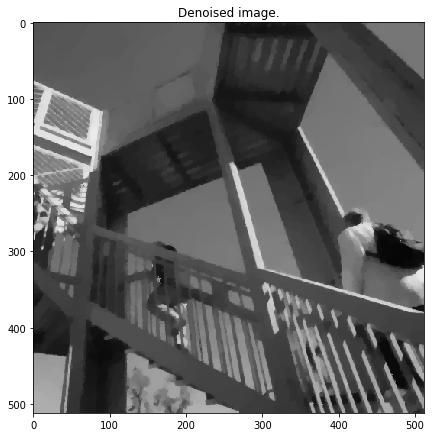

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(x_denoised_TV, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.subplots_adjust(top=3)
plt.title('Denoised image.')plt.show()

In [58]:
Lambda = 4

A = lambda x: 1/Lambda*x + D(Dadj(x))

z = solve_linear(A, D(y))
x_denoised_L2 = y - Dadj(z)

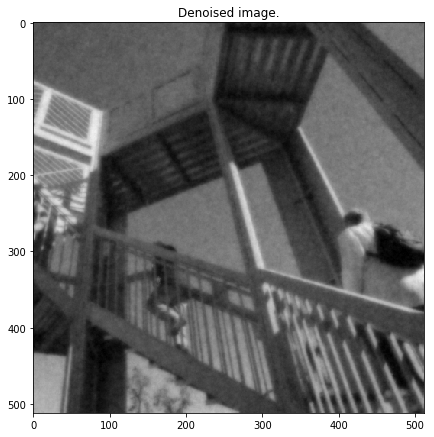

In [59]:
plt.figure(figsize=(7,7))
plt.imshow(x_denoised_L2, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.subplots_adjust(top=3)
plt.title('Denoised image.')
plt.show()

In [89]:
from skimage.restoration import denoise_tv_chambolle

x_denoised_tv = denoise_tv_chambolle(y, weight=0.4)

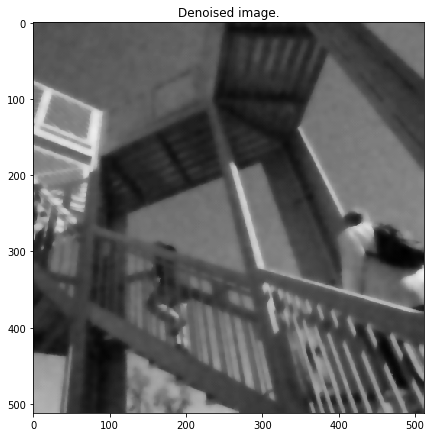

In [90]:
plt.figure(figsize=(7,7))
plt.imshow(x_denoised_tv, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.subplots_adjust(top=3)
plt.title('Denoised image.')
plt.show()

<img src="http://images.slideplayer.com/17/5347894/slides/slide_41.jpg" width=600>

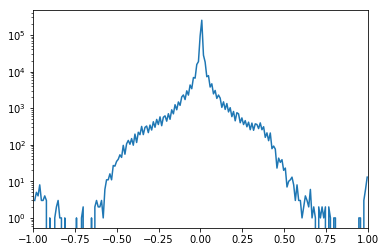

In [73]:
z = D(x)

heights, bins = np.histogram(z.flatten(), 200)
plt.semilogy(bins[1:], heights)
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

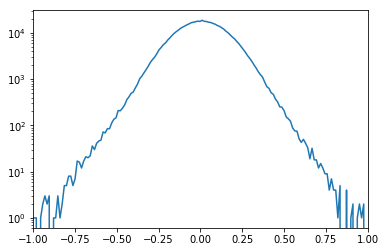

In [74]:
z = D(y)

heights, bins = np.histogram(z.flatten(), 200)
plt.semilogy(bins[1:], heights)
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

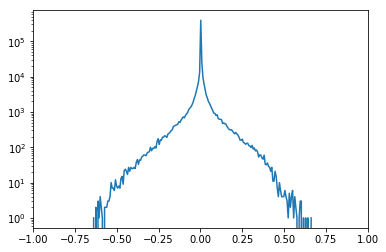

In [52]:
z = D(x_denoised_L1)

heights, bins = np.histogram(z.flatten(), 200)
plt.semilogy(bins[1:], heights)
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

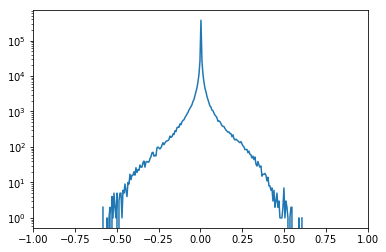

In [53]:
z = D(x_denoised_TV)

heights, bins = np.histogram(z.flatten(), 200)
plt.semilogy(bins[1:], heights)
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

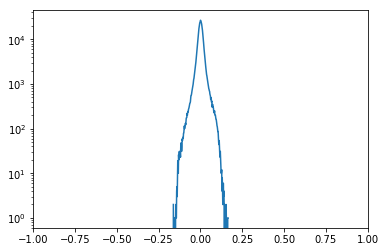

In [60]:
z = D(x_denoised_L2)

heights, bins = np.histogram(z.flatten(), 200)
plt.semilogy(bins[1:], heights)
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

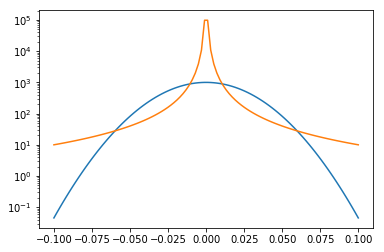

In [132]:
t = np.linspace(-0.1,0.1,100)
plt.semilogy(t, 1000*np.exp(-1000*np.abs(t)**2))
plt.semilogy(t, 0.1/np.abs(t)**2)
plt.show()

Пример 3:

$f(x) = x^TQx$

$x^TQx \leq x^TMx + 2x^T(Q-M)x_k + x_k^T(M - Q)x_k$, где $M \succcurlyeq Q$, например, $M = \lambda I$ если $\lambda \geq \lambda_{\max}(Q)$.


Рассмотрим задачу аппроксимации матрицы $R$ на основе части ее элементов с ограничением на ранг.

\begin{gather}
\underset{\lambda}{\text{min}} & \frac{1}{2} \sum_{(i,j) \in \Omega} (R_{ij} - X_{ij})^2\\
\text{s.t.} & \mathrm{rank}(X) \leq k
\end{gather}

Целевую функцию можно переписать как $\frac{1}{2}x^TQx - x^TQr$, где $x = \mathrm{vec}(X)$, $r = \mathrm{vec}(R)$ и $Q = \mathrm{diag}(q)$, $q_i = 1$, если $r_i$ известен, и $q_i = 0$ иначе. В этом случае $\lambda \geq \lambda_{\max}(Q) = 1$. 

$g(x|x_k) = \frac{\lambda}{2}\|x - y\|^2$, где $y = \frac{1}{\lambda}Qr - (\frac{1}{\lambda}Q -  I)x_k = \frac{1}{\lambda}Q(r - x_k) + x_k$.

Задача

\begin{gather}
\underset{\lambda}{\text{min}} & \frac{1}{2} \| X - Y \|_F^2\\
\text{s.t.} & \mathrm{rank}(X) \leq k
\end{gather}

имеет аналитическое решение, получаемое обнулением всех сингулярных чисел матрицы $Y$, кроме $k$ наибольших.

In [21]:
import scipy.io

mat = scipy.io.loadmat('./data/ratings.mat')
R = np.array(mat['R'].todense())

m,n = R.shape

In [38]:
O = R > 0

def mc_objective(X, R, O): 
    return 0.5 * np.linalg.norm(R - np.multiply(X, O), 'fro')**2

In [39]:
def rmse(X, R, O):
    n = np.count_nonzero(O)
    return np.sqrt(1./n*np.linalg.norm(R - np.multiply(X, O), 'fro')**2)

In [40]:
def SVT(X, k):
    U, S, V = np.linalg.svd(X, full_matrices=False)
    return U[:,0:k].dot(np.diag(S[0:k])).dot(V[0:k,:]) 

In [127]:
max_iter = 1000

X0 = np.random.rand(m,n)

k = 2

Lambda = 15

X = X0
for t in range(max_iter): 
    
    if t%100 == 0:
        print(mc_objective(X,R,O))
    
    Y = 1/Lambda*O*(R - X) + X 
    X = SVT(Y,k) 


3404.03997542
134.070011826
108.326638948
104.113130642
102.83258786
102.228613516
101.938615894
101.798240756
101.728642403
101.694003541


In [128]:
R_test = np.array(mat['R_test'].todense())
O_test = R_test > 0

RMSE = rmse(X, R_test, O_test)

print(RMSE)

0.934960455858
